In [1]:
import sys
sys.path.append("..")
from hcipy.hcipy import *
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def pupil(N):

    p = np.zeros([N,N])

    radius = N/2.
    [X,Y] = np.meshgrid(np.linspace(-(N-1)/2.,(N-1)/2.,N),np.linspace(-(N-1)/2.,(N-1)/2.,N))
    R = np.sqrt(pow(X,2)+pow(Y,2))
    p[R<=radius] = 1
    
    return p

def projectOntoDM(Z,nAct,wL):

    # Convert phase to optical path length and halve to
    # compensate for double pass of DM
    Z_DM = Z*wL/(2*np.pi)

    # Set commands only for valid actuators
    p = pupil(nAct)==1

    # Scale commands for Keck DM (1V = 0.6u)
    scale = 0.6e-6
    Z_coefs = Z_DM[p]/scale

    # Remove piston (average)
    #Z_coeffs = Z_coefs - np.mean(Z_coefs)

    return Z_coefs

In [3]:
wavelength = 5e-7
dt    = 1/1000
T     = 1
nAct  = 21
D     = 10.95
r0    = 16.5e-2   
k     = 2 * np.pi / wavelength
scale = 0.6e-6
Z_DM = np.zeros([nAct,nAct])
pup  = pupil(nAct) == 1
binning_factor = 8
pupil_grid     = make_pupil_grid(nAct*binning_factor, D)

t = np.arange(0, T, dt)

## Define Zernike basis set
## We're planning to subtract the first 3 modes: piston, tip, and tilt
mode_basis = make_zernike_basis(num_modes=3, D=D, grid=pupil_grid)
tiptilt = mode_basis[1:3] # the mode basis for just controlling tip and tilt
piston = mode_basis[:2] # the mode basis for just controlling piston

In [7]:
outer_scale   = 20 
wind_velocity = 15
Cn2           = r0**(-5. / 3) / (0.423 * k**2)
single_layer_atmos = InfiniteAtmosphericLayer(pupil_grid,  Cn_squared=Cn2, L0=outer_scale, 
                                              velocity=wind_velocity, use_interpolation=True)
single_modal_layer_atmos = ModalAdaptiveOpticsLayer(layer=single_layer_atmos, controlled_modes=mode_basis, lag=0) 
coeff_size = np.count_nonzero(pupil(nAct))
single_layer_turb = np.zeros((t.size, coeff_size))
for n in range(t.size):
    single_modal_layer_atmos.evolve_until(t[n])
    thephase = single_modal_layer_atmos.phase_for(wavelength)
    thephase_binned = thephase.reshape(nAct,binning_factor, nAct, binning_factor).mean(axis=3).mean(axis=1)
    # dimensions nAct x nAct
    
    ## Remove piston
    Z = thephase_binned * pup
    Z[Z==0] = np.nan
    #Z = Z - np.nanmean(Z)
    

    Z_coeffs = projectOntoDM(Z,nAct,wavelength)
    single_layer_turb[n,:] = Z_coeffs

#np.save('./single_layer_turb_volts.npy', single_layer_turb)

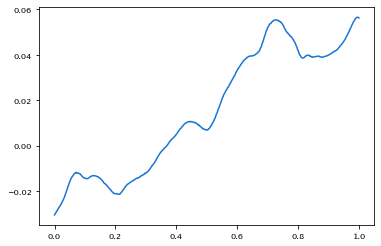

In [11]:
aberrations_var = np.sqrt((single_layer_turb**2).mean(axis=1))
aberrations_orig = single_layer_turb.mean(axis=1)
plt.plot(t, aberrations_orig)
plt.xlabel("Time (s)")
plt.ylabel("Aberration (mas)") # I assume this is sqrt(dx^2 + dy^2)?

In [ ]:
aberrations_var = np.sqrt((single_layer_turb**2).mean(axis=1))
aberrations_orig = single_layer_turb.mean(axis=1)
plt.plot(t, aberrations_orig)
plt.xlabel("Time (s)")
plt.ylabel("Aberration (mas)") # I assume this is sqrt(dx^2 + dy^2)?